In [148]:

%load_ext autoreload
%autoreload 2

import sys
import os
sys.path.append('../')

# Graph imports
import src.graph as graph
import src.logit_estimator as estimator
import src.utils as utils
import src.model_selection as model_selection
import src.gic as gic
import src.param_estimator as pe
import src.graph as graph
import src.model_selection as ms

# usual imports
import matplotlib.pyplot as plt
import math
import numpy as np
import pandas as pd
import seaborn as sns
import gc
import random
import networkx as nx

from IPython.display import display
from pyvis.network import Network

import pickle
import os

np.random.seed(42)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [132]:
datasets = f'../data/connectomes/'
connectomes = os.listdir(datasets)

In [133]:
for i in range(len(connectomes)):
    real_graph = nx.read_graphml(datasets + connectomes[i])
    print(connectomes[i])
    print("\tNodes:", real_graph.number_of_nodes())
    print("\tEdges:", real_graph.number_of_edges())
    print()


p.pacificus_neural.synaptic_2.graphml
	Nodes: 50
	Edges: 611

rhesus_cerebral.cortex_1.graphml
	Nodes: 91
	Edges: 1989

rattus.norvegicus_brain_1.graphml
	Nodes: 503
	Edges: 27667

mixed.species_brain_1.graphml
	Nodes: 65
	Edges: 1139

mouse_visual.cortex_2.graphml
	Nodes: 195
	Edges: 214

rattus.norvegicus_brain_2.graphml
	Nodes: 503
	Edges: 30088

p.pacificus_neural.synaptic_1.graphml
	Nodes: 54
	Edges: 511

mouse_visual.cortex_1.graphml
	Nodes: 29
	Edges: 44

rattus.norvegicus_brain_3.graphml
	Nodes: 496
	Edges: 33020

rhesus_interareal.cortical.network_2.graphml
	Nodes: 93
	Edges: 2667

rhesus_brain_1.graphml
	Nodes: 242
	Edges: 4090

mouse_retina_1.graphml
	Nodes: 1123
	Edges: 577350

kasthuri_graph_v4.graphml
	Nodes: 1029
	Edges: 1700

mouse_brain_1.graphml
	Nodes: 213
	Edges: 21807

drosophila_medulla_1.graphml
	Nodes: 1781
	Edges: 33641

c.elegans.herm_pharynx_1.graphml
	Nodes: 279
	Edges: 3225

rhesus_brain_2.graphml
	Nodes: 91
	Edges: 628

c.elegans_neural.male_1.graphml
	Nod

# Plot and Spectrum and model selection for different connectomes

In [159]:
def get_logit_graph(real_graph, d):
   # Estimation
   est = estimator.LogitRegEstimator(real_graph, d=d)
   features, labels = est.get_features_labels()
   result, params, pvalue = est.estimate_parameters(l1_wt=1, alpha=0, features=features, labels=labels)
   sigma = params[0]

   # Generation
   n = real_graph.shape[0]
   d = 0
   sigma = sigma
   n_iteration = 20000
   warm_up     = 10000
   params_dict = {
      "n": n,
      "d": d,
      "sigma": sigma,
      "n_iteration": n_iteration,
      "warm_up": warm_up
   }
   graph_model = graph.GraphModel(n=n, d=d, sigma=sigma)
   graphs, spec = graph_model.populate_edges( warm_up = warm_up, max_iterations = n_iteration, threshold = 5, stability_window = 10)
   return graphs[-1], sigma

def plot_graphs_in_matrix(sim_graphs_dict, result_dict, global_title, save_path=None):
    # Determine the size of the grid
    num_graphs = len(sim_graphs_dict)
    cols = 4  # Or another number that suits your display
    rows = math.ceil(num_graphs / cols)

    # Create a figure with subplots
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 5))
    axes = axes.flatten()  # Flatten the axes array for easy iteration

    for ax, (name, G) in zip(axes, sim_graphs_dict.items()):
        # Use a layout
        pos = nx.kamada_kawai_layout(G)

        # Draw nodes with a node color based on degree
        node_color = [G.degree(v) for v in G]
        #node_size = [G.degree(v) * 10 for v in G]  # Adjust node size based on degree
        if name == 'GRG':
            scale_factor = 0.1  # Adjust this factor as needed to reduce the size suitably
            node_size = [G.degree(v) * scale_factor for v in G]
        else:
            node_size = [G.degree(v) * 10 for v in G]

        nx.draw_networkx_nodes(G, pos, node_color=node_color, node_size=node_size, cmap=plt.cm.viridis, ax=ax)

        # Draw edges with transparency
        nx.draw_networkx_edges(G, pos, alpha=0.5, ax=ax)

        # Set plot details for each subplot
        if name!='Real':
            ax.set_title(f'{name} Graph, GIC: {result_dict[name]["GIC"]:.2f}')
            ax.axis('off')  # Turn off the axis
        else:
            ax.set_title(f'{name} Graph')
            ax.axis('off')  # Turn off the axis

    # Hide any unused axes if the number of graphs is less than rows*cols
    for i in range(len(sim_graphs_dict), len(axes)):
        axes[i].set_visible(False)

    fig.suptitle(global_title, fontsize=16, fontweight='bold')

    # Adjust layout
    plt.tight_layout()

    if save_path:
        fig.savefig(save_path, bbox_inches='tight')

    plt.show()
    return fig

In [160]:
def clean_and_convert(param):
    cleaned_param = ''.join(c for c in param if c.isdigit() or c == '.' or c == '-')
    return float(cleaned_param)



                         Results: Logit
Model:              Logit            Method:           MLE       
Dependent Variable: y                Pseudo R-squared: 0.155     
Date:               2024-07-11 21:01 AIC:              745.0726  
No. Observations:   1225             BIC:              760.4047  
Df Model:           2                Log-Likelihood:   -369.54   
Df Residuals:       1222             LL-Null:          -437.39   
Converged:          1.0000           LLR p-value:      3.4081e-30
No. Iterations:     11.0000          Scale:            1.0000    
-------------------------------------------------------------------
          Coef.    Std.Err.      z       P>|z|     [0.025    0.975]
-------------------------------------------------------------------
const    -2.9218     0.1393   -20.9761   0.0000   -3.1948   -2.6488
x1        0.0210     0.0025     8.4585   0.0000    0.0161    0.0259
x2        0.0437     0.0059     7.3947   0.0000    0.0321    0.0553

iteration: 0
iteration:

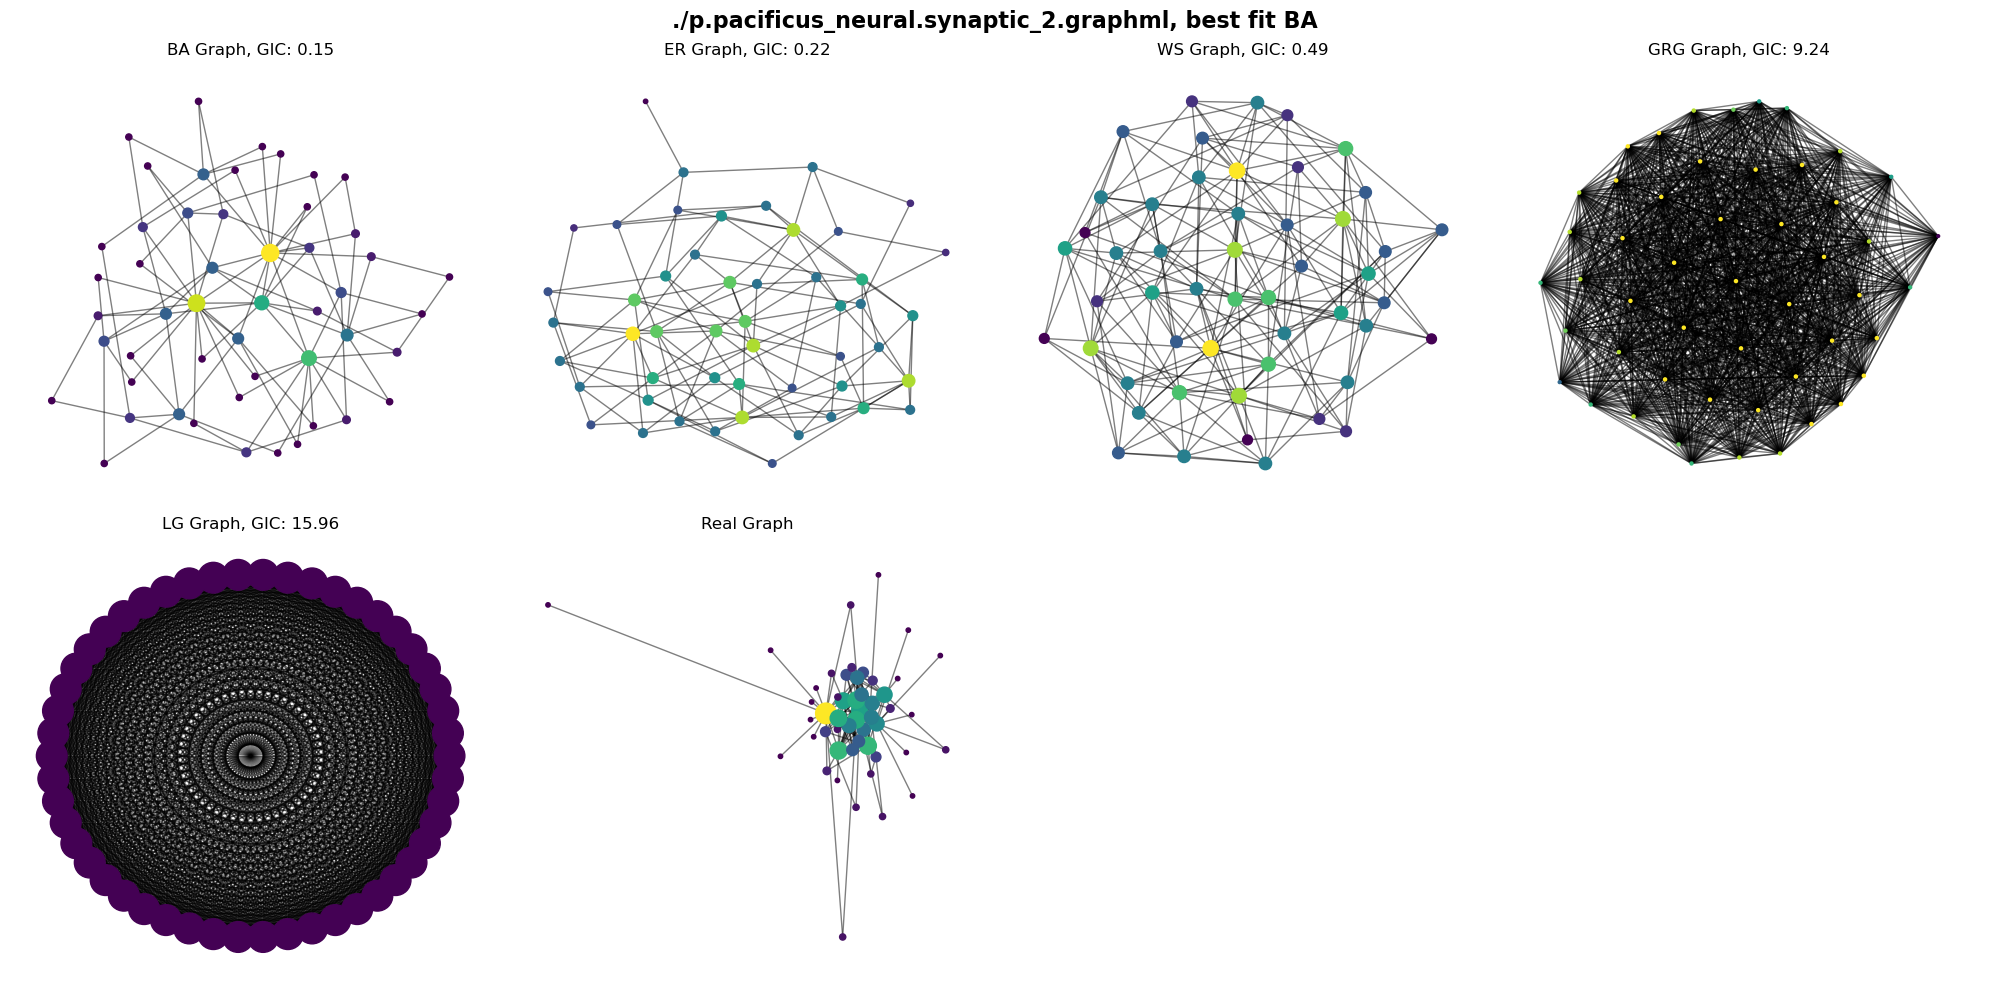

                         Results: Logit
Model:              Logit            Method:           MLE       
Dependent Variable: y                Pseudo R-squared: 0.039     
Date:               2024-07-11 21:01 AIC:              5060.3935 
No. Observations:   4095             BIC:              5079.3461 
Df Model:           2                Log-Likelihood:   -2527.2   
Df Residuals:       4092             LL-Null:          -2630.8   
Converged:          1.0000           LLR p-value:      1.0442e-45
No. Iterations:     14.0000          Scale:            1.0000    
-------------------------------------------------------------------
          Coef.    Std.Err.      z       P>|z|     [0.025    0.975]
-------------------------------------------------------------------
const    -2.8269     0.1684   -16.7846   0.0000   -3.1570   -2.4968
x1        0.0353     0.0051     6.9463   0.0000    0.0253    0.0453
x2        0.0654     0.0057    11.5752   0.0000    0.0543    0.0765

iteration: 0
iteration:

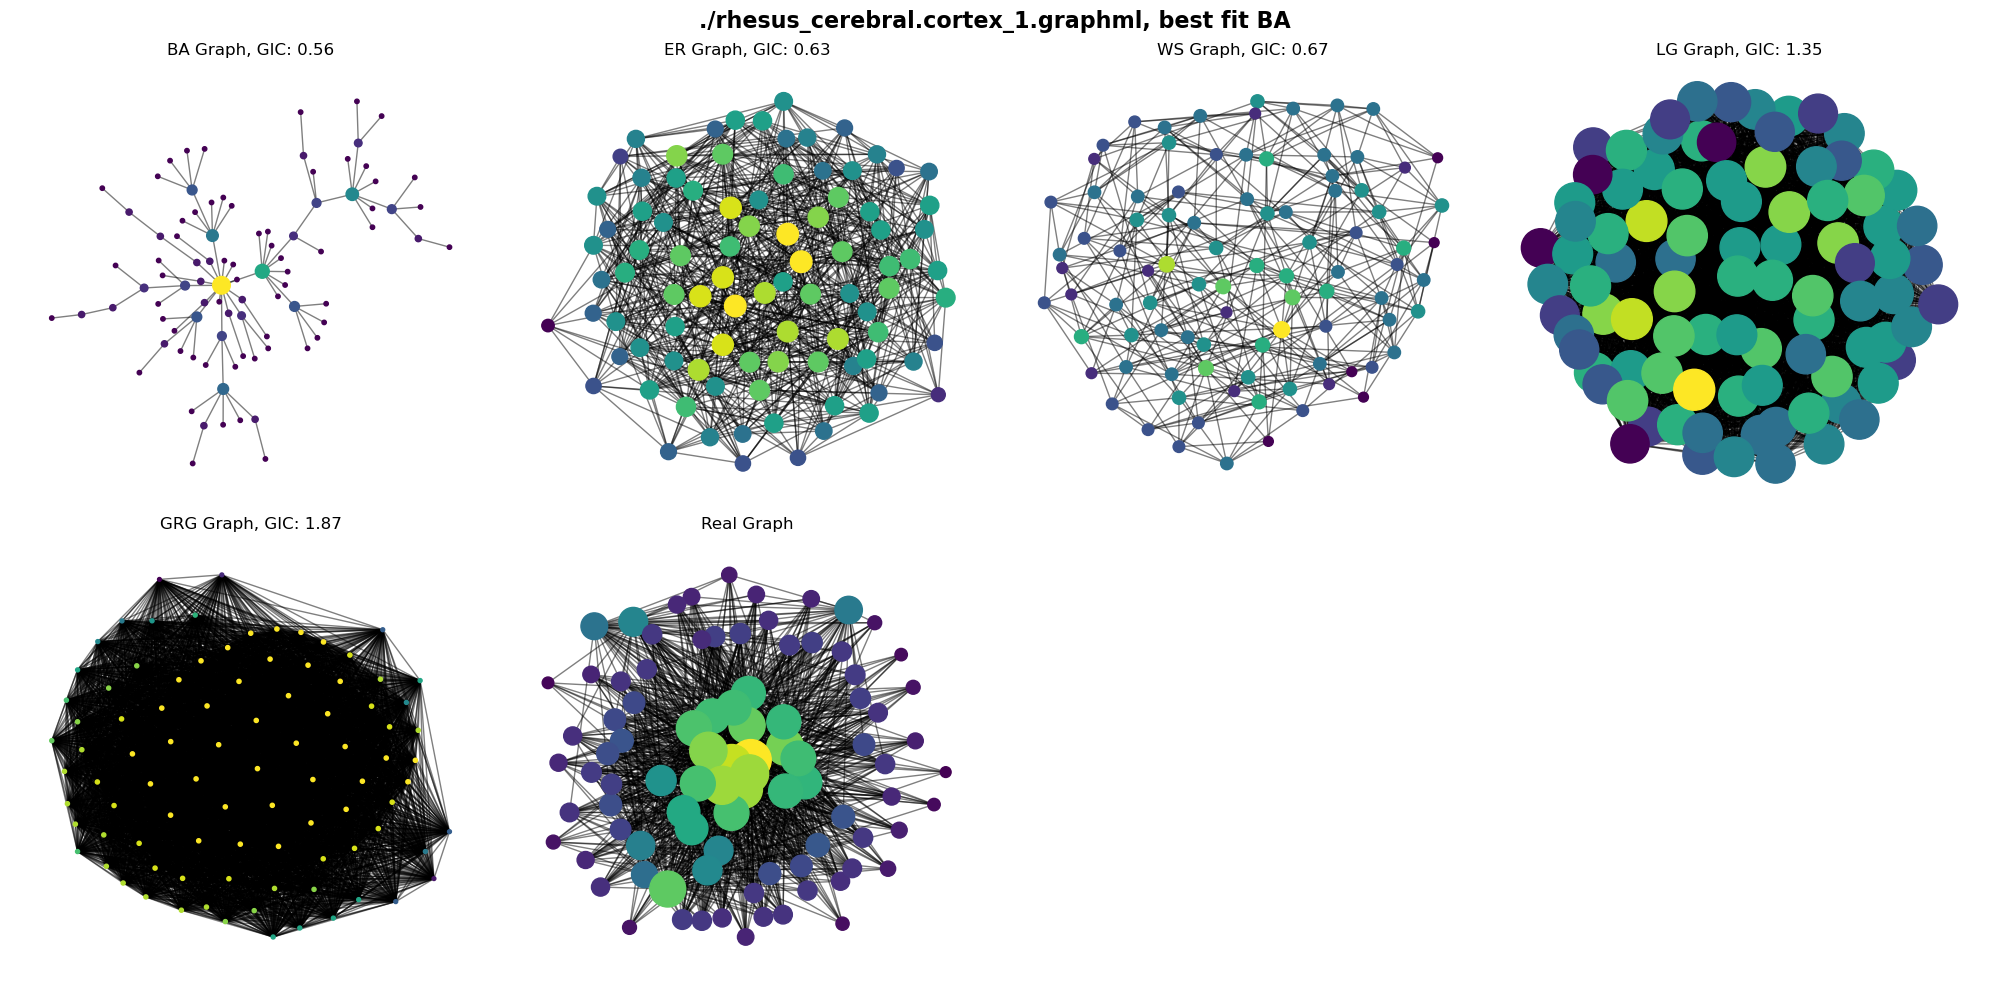

/Users/maruanottoni/miniforge3/envs/gt/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/gt/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:2443: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


                         Results: Logit
Model:              Logit            Method:           MLE       
Dependent Variable: y                Pseudo R-squared: 0.206     
Date:               2024-07-11 21:01 AIC:              95295.4301
No. Observations:   126253           BIC:              95324.6682
Df Model:           2                Log-Likelihood:   -47645.   
Df Residuals:       126250           LL-Null:          -59974.   
Converged:          1.0000           LLR p-value:      0.0000    
No. Iterations:     18.0000          Scale:            1.0000    
-------------------------------------------------------------------
         Coef.    Std.Err.       z       P>|z|     [0.025    0.975]
-------------------------------------------------------------------
const   -3.6090     0.0209   -172.9344   0.0000   -3.6499   -3.5681
x1       0.0120     0.0001     87.4042   0.0000    0.0118    0.0123
x2       0.0086     0.0001     79.0788   0.0000    0.0084    0.0088

iteration: 0
iteration:

In [170]:
for i in range(len(connectomes)):
   real_graph = nx.read_graphml(datasets + connectomes[i])
   real_graph = nx.to_numpy_array(real_graph)
   logit_graph, sigma = get_logit_graph(real_graph=real_graph, d=0) # TODO: Improve the estimation of d
   #logit_graph = nx.to_numpy_array(logit_graph)

   selector = ms.GraphModelSelection(graph=nx.from_numpy_array(real_graph),
                                    log_graph=nx.from_numpy_array(logit_graph),
                                    log_params=sigma,
                                    #models=["ER", "WS", "GRG", "BA", "KR", "LG"],
                                    models=["ER", "WS", "GRG", "BA", "LG"],
                                    parameters=[ {'lo': 0.01, 'hi': 1}, # ER
                                                {'lo': 0.01, 'hi': 1}, # WS k=8
                                                {'lo': 1, 'hi': 3},    # GRG
                                                {'lo': 1, 'hi': 5},    # BA
                                                #{'lo': 1, 'hi': 3},    # KR
                                             ]
                                    )

   result = selector.select_model()
   result_dict = {item['model']: {'param': clean_and_convert(item['param']), 'GIC': item['GIC']} for item in result['estimates']}
   min_gic_key = min(result_dict, key=lambda k: result_dict[k]['GIC']) # Get best fit
   model_names = result_dict.keys() 

   sim_graphs_dict = {}
   for model in model_names:
      if model!='LG':
         func = selector.model_function(model_name=model)
         graph_sim = func(real_graph.shape[0], float(result_dict[model]['param']))
         sim_graphs_dict[model] = graph_sim
      elif model=='LG':
         sim_graphs_dict[model] = nx.from_numpy_array(logit_graph)

   sim_graphs_dict['Real'] = nx.from_numpy_array(real_graph)
   fig = plot_graphs_in_matrix(sim_graphs_dict,
                               result_dict,
                               global_title=f'./{connectomes[i]}, best fit {min_gic_key}',
                               save_path=f'./imgs_connectomes/{connectomes[i]}.png')

# Make the comparision of the mean of different species

In [134]:
# First make a df with index = dataset and the values of the estimation
d = 0
data = {}
for i in range(len(connectomes)):
    real_graph = nx.read_graphml(datasets + connectomes[i])
    print(connectomes[i])
    # Make estimation
    g = nx.to_numpy_array(real_graph.to_undirected())
    est = estimator.LogitRegEstimator(g, d=d)
    features, labels = est.get_features_labels()
    result, params, pvalue = est.estimate_parameters(l1_wt=1, alpha=0, features=features, labels=labels)
    data[connectomes[i]] = result



p.pacificus_neural.synaptic_2.graphml
                         Results: Logit
Model:              Logit            Method:           MLE       
Dependent Variable: y                Pseudo R-squared: 0.213     
Date:               2024-07-11 20:34 AIC:              694.6735  
No. Observations:   1225             BIC:              710.0056  
Df Model:           2                Log-Likelihood:   -344.34   
Df Residuals:       1222             LL-Null:          -437.39   
Converged:          1.0000           LLR p-value:      3.8768e-41
No. Iterations:     13.0000          Scale:            1.0000    
-------------------------------------------------------------------
          Coef.    Std.Err.      z       P>|z|     [0.025    0.975]
-------------------------------------------------------------------
const    -3.8233     0.2033   -18.8023   0.0000   -4.2219   -3.4248
x1        0.0236     0.0026     8.9575   0.0000    0.0184    0.0287
x2        0.0380     0.0037    10.3066   0.0000    0.0

/Users/maruanottoni/miniforge3/envs/gt/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/gt/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:2443: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


rattus.norvegicus_brain_1.graphml


/Users/maruanottoni/miniforge3/envs/gt/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/gt/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:2443: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


                         Results: Logit
Model:              Logit            Method:           MLE       
Dependent Variable: y                Pseudo R-squared: 0.718     
Date:               2024-07-11 20:34 AIC:              33848.4629
No. Observations:   126253           BIC:              33877.7010
Df Model:           2                Log-Likelihood:   -16921.   
Df Residuals:       126250           LL-Null:          -59974.   
Converged:          1.0000           LLR p-value:      0.0000    
No. Iterations:     20.0000          Scale:            1.0000    
-------------------------------------------------------------------
         Coef.    Std.Err.       z       P>|z|     [0.025    0.975]
-------------------------------------------------------------------
const   -6.5839     0.0394   -167.0025   0.0000   -6.6612   -6.5066
x1       0.0117     0.0001    145.9805   0.0000    0.0115    0.0118
x2       0.0119     0.0001    136.0039   0.0000    0.0117    0.0121

mixed.species_brain_1.g

/Users/maruanottoni/miniforge3/envs/gt/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/gt/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:2443: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


                         Results: Logit
Model:              Logit            Method:           MLE       
Dependent Variable: y                Pseudo R-squared: 0.727     
Date:               2024-07-11 20:34 AIC:              34068.5331
No. Observations:   126262           BIC:              34097.7715
Df Model:           2                Log-Likelihood:   -17031.   
Df Residuals:       126259           LL-Null:          -62346.   
Converged:          1.0000           LLR p-value:      0.0000    
No. Iterations:     20.0000          Scale:            1.0000    
-------------------------------------------------------------------
         Coef.    Std.Err.       z       P>|z|     [0.025    0.975]
-------------------------------------------------------------------
const   -6.6579     0.0399   -166.8989   0.0000   -6.7361   -6.5797
x1       0.0116     0.0001    147.3526   0.0000    0.0114    0.0117
x2       0.0118     0.0001    135.5384   0.0000    0.0116    0.0120

p.pacificus_neural.syna

/Users/maruanottoni/miniforge3/envs/gt/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/gt/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:2443: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


                         Results: Logit
Model:              Logit            Method:           MLE       
Dependent Variable: y                Pseudo R-squared: 0.692     
Date:               2024-07-11 20:34 AIC:              39078.4640
No. Observations:   122769           BIC:              39107.6182
Df Model:           2                Log-Likelihood:   -19536.   
Df Residuals:       122766           LL-Null:          -63371.   
Converged:          1.0000           LLR p-value:      0.0000    
No. Iterations:     19.0000          Scale:            1.0000    
-------------------------------------------------------------------
         Coef.    Std.Err.       z       P>|z|     [0.025    0.975]
-------------------------------------------------------------------
const   -7.0532     0.0432   -163.1188   0.0000   -7.1380   -6.9685
x1       0.0109     0.0001    145.8076   0.0000    0.0108    0.0111
x2       0.0122     0.0001    134.4764   0.0000    0.0120    0.0124

rhesus_interareal.corti

/Users/maruanottoni/miniforge3/envs/gt/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/gt/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:2443: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))
/Users/maruanottoni/miniforge3/envs/gt/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/gt/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:2443: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


mouse_retina_1.graphml


/Users/maruanottoni/miniforge3/envs/gt/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/gt/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:2443: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


                          Results: Logit
Model:              Logit            Method:           MLE        
Dependent Variable: y                Pseudo R-squared: 0.209      
Date:               2024-07-11 20:34 AIC:              411256.2943
No. Observations:   630003           BIC:              411290.3547
Df Model:           2                Log-Likelihood:   -2.0563e+05
Df Residuals:       630000           LL-Null:          -2.5982e+05
Converged:          1.0000           LLR p-value:      0.0000     
No. Iterations:     14.0000          Scale:            1.0000     
--------------------------------------------------------------------
          Coef.    Std.Err.       z       P>|z|     [0.025    0.975]
--------------------------------------------------------------------
const    -3.6087     0.0084   -429.6204   0.0000   -3.6252   -3.5922
x1        0.0006     0.0000    205.1312   0.0000    0.0006    0.0006
x2        0.0009     0.0000    219.8568   0.0000    0.0009    0.0009

kasthuri

/Users/maruanottoni/miniforge3/envs/gt/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/gt/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:2443: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


                         Results: Logit
Model:              Logit            Method:           MLE       
Dependent Variable: y                Pseudo R-squared: 0.109     
Date:               2024-07-11 20:34 AIC:              18975.4361
No. Observations:   528906           BIC:              19008.9718
Df Model:           2                Log-Likelihood:   -9484.7   
Df Residuals:       528903           LL-Null:          -10641.   
Converged:          1.0000           LLR p-value:      0.0000    
No. Iterations:     38.0000          Scale:            1.0000    
-------------------------------------------------------------------
         Coef.    Std.Err.       z       P>|z|     [0.025    0.975]
-------------------------------------------------------------------
const   -6.3051     0.0309   -204.0779   0.0000   -6.3656   -6.2445
x1       0.0329     0.0005     65.3190   0.0000    0.0319    0.0339
x2       0.0399     0.0025     16.0255   0.0000    0.0350    0.0447

mouse_brain_1.graphml
 

/Users/maruanottoni/miniforge3/envs/gt/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/gt/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:2443: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


drosophila_medulla_1.graphml


/Users/maruanottoni/miniforge3/envs/gt/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/gt/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:2443: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


                          Results: Logit
Model:              Logit            Method:           MLE        
Dependent Variable: y                Pseudo R-squared: 0.076      
Date:               2024-07-11 20:34 AIC:              102732.2358
No. Observations:   1585195          BIC:              102769.0644
Df Model:           2                Log-Likelihood:   -51363.    
Df Residuals:       1585192          LL-Null:          -55598.    
Converged:          1.0000           LLR p-value:      0.0000     
No. Iterations:     27.0000          Scale:            1.0000     
--------------------------------------------------------------------
          Coef.    Std.Err.       z       P>|z|     [0.025    0.975]
--------------------------------------------------------------------
const    -5.2996     0.0113   -470.7546   0.0000   -5.3216   -5.2775
x1        0.0003     0.0000     29.6139   0.0000    0.0002    0.0003
x2        0.0004     0.0000    105.8166   0.0000    0.0004    0.0004

c.elegan

/Users/maruanottoni/miniforge3/envs/gt/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/gt/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:2443: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


                         Results: Logit
Model:              Logit            Method:           MLE       
Dependent Variable: y                Pseudo R-squared: 0.161     
Date:               2024-07-11 20:34 AIC:              17320.0721
No. Observations:   36919            BIC:              17345.6215
Df Model:           2                Log-Likelihood:   -8657.0   
Df Residuals:       36916            LL-Null:          -10320.   
Converged:          1.0000           LLR p-value:      0.0000    
No. Iterations:     15.0000          Scale:            1.0000    
-------------------------------------------------------------------
          Coef.    Std.Err.      z       P>|z|     [0.025    0.975]
-------------------------------------------------------------------
const    -4.7845     0.0576   -82.9992   0.0000   -4.8975   -4.6715
x1        0.0503     0.0010    48.8874   0.0000    0.0483    0.0523
x2        0.0382     0.0013    30.2917   0.0000    0.0357    0.0407



In [135]:
#data['p.pacificus_neural.synaptic_2.graphml'].summary2()

In [136]:
species_mapping = {
    'p.pacificus_neural.synaptic_2.graphml': 'worm',
    'rhesus_cerebral.cortex_1.graphml': 'macaque',
    'rattus.norvegicus_brain_1.graphml': 'rat',
    'mixed.species_brain_1.graphml': 'cat',
    'mouse_visual.cortex_2.graphml': 'mouse',
    'rattus.norvegicus_brain_2.graphml': 'rat',
    'p.pacificus_neural.synaptic_1.graphml': 'worm',
    'mouse_visual.cortex_1.graphml': 'mouse',
    'rattus.norvegicus_brain_3.graphml': 'rat',
    'rhesus_interareal.cortical.network_2.graphml': 'macaque',
    'rhesus_brain_1.graphml': 'macaque',
    'mouse_retina_1.graphml': 'mouse',
    'kasthuri_graph_v4.graphml': 'mouse',
    'mouse_brain_1.graphml': 'mouse',
    'drosophila_medulla_1.graphml': 'fly',
    'c.elegans.herm_pharynx_1.graphml': 'celegans',
    'rhesus_brain_2.graphml': 'macaque',
    'c.elegans_neural.male_1.graphml': 'celegans'
}


In [137]:
def extract_relevant_info(results_wrapper, d):
    # Get the summary2 dataframe
    summary_df = results_wrapper.summary2().tables[1]  # Coefficients table
    aic = results_wrapper.summary2().tables[0].iloc[2, 3]  # AIC value
    bic = results_wrapper.summary2().tables[0].iloc[3, 3]  # BIC value
    
    # Extract information for 'const' if it exists
    if 'const' in summary_df.index:
        const_info = summary_df.loc['const', ['Coef.', 'Std.Err.', '[0.025', '0.975]']]
    else:
        # If no constant, insert NaNs or some placeholder
        const_info = pd.Series([pd.NA] * 4, index=['Coef.', 'Std.Err.', '[0.025', '0.975]'])
    
    # Create a small DataFrame for this model
    data = {
        'AIC': aic,
        'BIC': bic,
        'sigma': const_info['Coef.'],
        'Std Error of sigma': const_info['Std.Err.'],
        '0.025 CI of sigma': const_info['[0.025'],
        '0.975 CI of sigma': const_info['0.975]'],
        'Depth (d)': d,
    }
    
    return pd.DataFrame([data])


In [138]:
all_data_d_0 = [extract_relevant_info(wrapper, d=0) for wrapper in data.values()]
df_d_0 = pd.concat(all_data_d_0, keys=data.keys())  # Use keys as index

all_data_d_1 = [extract_relevant_info(wrapper, d=1) for wrapper in data.values()]
df_d_1 = pd.concat(all_data_d_1, keys=data.keys())  # Use keys as index


In [139]:
final_df = pd.concat((df_d_1,df_d_0), axis=0)
final_df = final_df.reset_index(level=1, drop=True)

final_df['species'] = final_df.index.map(species_mapping)
final_df

,AIC,BIC,sigma,Std Error of sigma,0.025 CI of sigma,0.975 CI of sigma,Depth (d),species
p.pacificus_neural.synaptic_2.graphml,694.6735,710.0056,-3.823346,2.033448e-01,-4.221894e+00,-3.424798e+00,1,worm
rhesus_cerebral.cortex_1.graphml,3726.1077,3745.0602,-3.968125,1.219859e-01,-4.207213e+00,-3.729037e+00,1,macaque
rattus.norvegicus_brain_1.graphml,33848.4629,33877.7010,-6.583911,3.942402e-02,-6.661181e+00,-6.506641e+00,1,rat
mixed.species_brain_1.graphml,2209.2066,2226.1270,-4.622072,2.235602e-01,-5.060242e+00,-4.183902e+00,1,cat
mouse_visual.cortex_2.graphml,1511.9046,1535.4477,-6.392157,1.622970e-01,-6.710253e+00,-6.074061e+00,1,mouse
rattus.norvegicus_brain_2.graphml,34068.5331,34097.7715,-6.657912,3.989189e-02,-6.736098e+00,-6.579725e+00,1,rat
p.pacificus_neural.synaptic_1.graphml,725.2114,741.0098,-3.988928,1.987175e-01,-4.378407e+00,-3.599449e+00,1,worm
mouse_visual.cortex_1.graphml,260.5016,272.5206,-3.279194,3.399969e-01,-3.945576e+00,-2.612812e+00,1,mouse
rattus.norvegicus_brain_3.graphml,39078.4640,39107.6182,-7.053237,4.323988e-02,-7.137986e+00,-6.968489e+00,1,rat
rhesus_interareal.cortical.network_2.graphml,6.0000,25.0837,-540.314360,7.969374e+10,-1.561969e+11,1.561969e+11,1,macaque


In [140]:
final_df.to_csv('estimation_results_connectomes.csv')

In [141]:
final_df_d0 = final_df[final_df['Depth (d)'] == 0]
df_species = final_df_d0[['species','0.025 CI of sigma', '0.975 CI of sigma','sigma']].groupby('species').median()
df_species

,0.025 CI of sigma,0.975 CI of sigma,sigma
species,,,
cat,-5.060242,-4.183902,-4.622072
celegans,-4.332286,-4.145842,-4.239064
fly,-5.321636,-5.277507,-5.299571
macaque,-6.001136,-4.128674,-5.690691
mouse,-6.365622,-6.074061,-6.305068
rat,-6.736098,-6.579725,-6.657912
worm,-4.300151,-3.512123,-3.906137


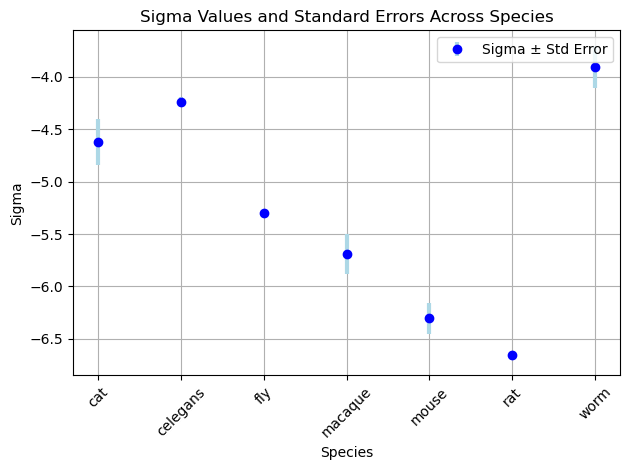

In [127]:
fig, ax = plt.subplots()
ax.errorbar(df_species.index, df_species['sigma'], yerr=df_species['Std Error of sigma'], fmt='o', color='b', 
            ecolor='lightblue', elinewidth=3, capsize=0, label='Sigma ± Std Error')

# Adding titles and labels
ax.set_title('Sigma Values and Standard Errors Across Species')
ax.set_xlabel('Species')
ax.set_ylabel('Sigma')

# Adding grid
ax.grid(True)

# Show the plot
plt.xticks(rotation=45)  # Rotate species names for better readability
plt.legend()
plt.tight_layout()  # Adjust layout to make room for the rotated x-labels
plt.show()


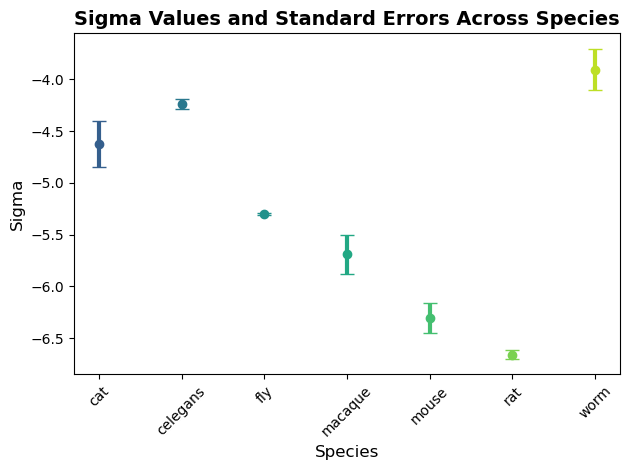

In [130]:
# Using a style
#plt.style.use('seaborn-darkgrid')  # Using seaborn style for a nicer background

# Create plot
fig, ax = plt.subplots()
colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(df_species)))  # Generate a colormap

# Errorbar plot with color mapping
for (i, (idx, row)), color in zip(enumerate(df_species.iterrows()), colors):
    ax.errorbar(idx, row['sigma'], yerr=row['Std Error of sigma'], fmt='o', color=color,
                ecolor=color, elinewidth=3, capsize=5, label=f'{idx}' if i == 0 else "")

# Enhancing the plot
ax.set_title('Sigma Values and Standard Errors Across Species', fontsize=14, fontweight='bold')
ax.set_xlabel('Species', fontsize=12)
ax.set_ylabel('Sigma', fontsize=12)
#ax.legend(title="Species", title_fontsize='13', fontsize='11')

# Customizing tick parameters
ax.tick_params(axis='x', labelrotation=45)
ax.tick_params(axis='both', labelsize=10)

# Fine-tuning layout and display
plt.tight_layout()  # Adjust layout to make room for the rotated x-labels
plt.show()

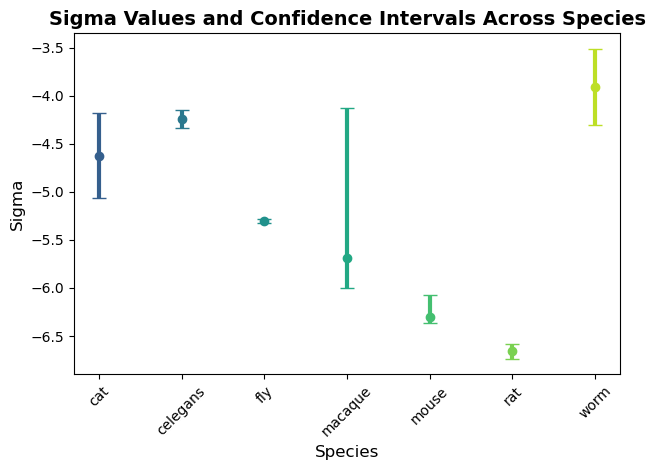

In [144]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

fig, ax = plt.subplots()
colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(df_species)))  # Generate a colormap

# Errorbar plot with color mapping
for (i, (idx, row)), color in zip(enumerate(df_species.iterrows()), colors):
    ax.errorbar(idx, row['sigma'], yerr=[[row['sigma'] - row['0.025 CI of sigma']], [row['0.975 CI of sigma'] - row['sigma']]], 
                fmt='o', color=color, ecolor=color, elinewidth=3, capsize=5, label=f'{idx}' if i == 0 else "")

# Enhancing the plot
ax.set_title('Sigma Values and Confidence Intervals Across Species', fontsize=14, fontweight='bold')
ax.set_xlabel('Species', fontsize=12)
ax.set_ylabel('Sigma', fontsize=12)
# ax.legend(title="Species", title_fontsize='13', fontsize='11')

# Customizing tick parameters
ax.tick_params(axis='x', labelrotation=45)
ax.tick_params(axis='both', labelsize=10)

# Fine-tuning layout and display
plt.tight_layout()  # Adjust layout to make room for the rotated x-labels
plt.show()
